<a href="https://colab.research.google.com/github/arpithabraj/Kannada-MNIST/blob/master/Kannada_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Kannada-MNIST
![alt text](https://storage.googleapis.com/kaggle-media/competitions/Kannada-MNIST/kannada.png)

Availability of GPU is found out using: [source](https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=oM_8ELnJq_wd)

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


The Google drive is mounted and datasets are downloaded for training the model and testing the CNN Model

In [0]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_list = drive.ListFile({'q': "'17HstX1p1ehiPs2BAFNXrgi6VINbA5_Hk' in parents and trashed=false"}).GetList()

In [0]:
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: dig_mnist.csv, id: 1La2YQ8jrLpBmge80Xl_YFUSBDMHM_fNg
title: train.csv, id: 1g1vIDGvuOgaBAEbaMJNXllgQcF6HehqP
title: Dig-MNIST.csv, id: 1b3U8fNaYEp5-87zubBXzC__9-AIdXjkk
title: test.csv, id: 1SoJNX74k-q844Xk5v7pYlNYAzvr8JKEG
title: sample_submission.csv, id: 16QRueiLAPABeWg5GDsoNpqRNjVfJIvlA


In [0]:
train_1 = drive.CreateFile({'id': '1g1vIDGvuOgaBAEbaMJNXllgQcF6HehqP'})
train_1.GetContentFile('train_1.csv')

In [0]:
test_1 = drive.CreateFile({'id': '1SoJNX74k-q844Xk5v7pYlNYAzvr8JKEG'})
test_1.GetContentFile('test_1.csv')

Following tools are imported:
*   pandas : It's used to handle the csv files.
*   matplotlib & seaborn : Used for charting and plotting.
*   sklearn : ML library for splitting our data.
*   keras : Deep learning library used for building CNN Network.

In [0]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers

import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

loading the csv data (training and testing data)

In [0]:
train = pd.read_csv('train_1.csv')
train = train.dropna(axis=0, how='any')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
test = pd.read_csv('test_1.csv')
test = test.dropna(axis=0, how='any')
test.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0




*   The Train  dataset has 60000 rows and 785 columns. First column are labels for training
*   The Test  dataset has 5000 rows and 785 columns. First column are idsand are rejected in further steps



In [0]:
print("Train set shape = " +str(train.shape))
print("Test set shape = " +str(test.shape))


Train set shape = (60000, 785)
Test set shape = (5000, 785)


Label values ( which are found in 1st column) are taken from **train** and assigned to Y_train for training the model

In [0]:
X_train=train.drop('label',axis=1)
Y_train=train.label

In [0]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
Y_train.head()

0    0
1    1
2    2
3    3
4    4
Name: label, dtype: int64

In [0]:
test=test.drop('id',axis=1)

* Plot to show that all of the classes has equal distribution.
* There are 6000 examples of each numbers in kannada in the the training dataset

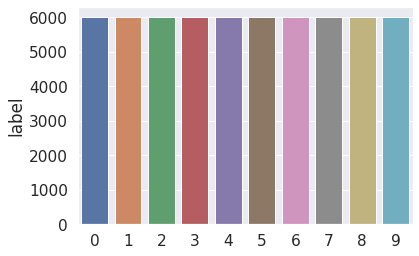

In [0]:
y=train.label.value_counts()
sns.barplot(y.index,y)


> * The 1st column from train is assigned to Y_train for training the model 

In [0]:
X_train=train.drop('label',axis=1)
Y_train=train.label

#### Normalize Pixel Values
The pixel values are integers with values between 0 and 255. Each pixel is normalized to obtain alue between 0 and 1. This is achieved by dividing all pixels values by the largest pixel value; that is 255.

In [0]:
X_train=X_train/255
test=test/255

* Data is reshaped into 60000 examples of height 28 and width 28 and 1 channel.

In [0]:
X_train=X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

In [0]:
print('The shape of train set now is',X_train.shape)
print('The shape of test set now is',test.shape)

The shape of train set now is (60000, 28, 28, 1)
The shape of test set now is (5000, 28, 28, 1)


* Keras inbuild library to_categorical() is used to do the on-hot encoding of lables in Y_train.

In [0]:
Y_train=to_categorical(Y_train)


## Splitting training data into train and validation

* 15 percent of the training data will be used for validation purpose.

In [0]:
X_train,X_test,y_train,y_test=train_test_split(X_train,Y_train,random_state=42,test_size=0.15)

* The first column in kannada represents "**9**"



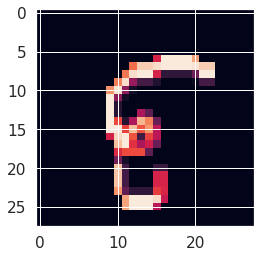

In [0]:
plt.imshow(X_train[0][:,:,0])

![alt text](https://i0.wp.com/s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/12/Screenshot-from-2018-12-10-14-07-58.png?resize=767%2C200&ssl=1)

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation ='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation ='relu'),
    tf.keras.layers.BatchNormalization(momentum=0.15),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation ='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation ='relu'),
    tf.keras.layers.BatchNormalization(momentum=0.15),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation ='relu'),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation ='relu'),
    tf.keras.layers.BatchNormalization(momentum=0.15),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation ='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax')
])


Deeplearning architecture

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_26 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 14, 14, 64)       

Initializing Learning rates, Batch size, Epochs, Optimizer and Mertics for training

In [0]:
initial_learning_rate=0.001
batch_size = 1024
epochs = 20
input_shape = (28, 28, 1)

In [0]:
model.compile(loss="categorical_crossentropy",
              optimizer=RMSprop(lr=initial_learning_rate),
              metrics=['accuracy'])

In [0]:
history = model.fit(X_train,y_train, batch_size=batch_size,
                    epochs = epochs, validation_data = (X_test,y_test)
                    , steps_per_epoch=X_train.shape[0] // batch_size)

Train on 51000 samples, validate on 9000 samples
Epoch 1/20
49976/51000 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.9975 - val_loss: 0.0195 - val_accuracy: 0.9961


##Evaluating our approach

In [0]:
y_pre_test=model.predict(X_test)
y_pre_test=np.argmax(y_pre_test,axis=1)
y_test=np.argmax(y_test,axis=1)

Confusion matrix for evaluating multiclass classifications. Misclassified classes are obtained and plotted with Seaborn plotting tool.

In [0]:
conf=confusion_matrix(y_test,y_pre_test)
conf=pd.DataFrame(conf,index=range(0,10),columns=range(0,10))

In [0]:
conf

,0,1,2,3,4,5,6,7,8,9
0,848,9,0,0,0,0,0,1,0,0
1,0,912,0,0,0,0,0,0,0,1
2,1,0,907,0,0,0,0,0,0,0
3,0,0,0,883,1,0,0,6,0,0
4,0,0,0,0,926,0,0,0,0,0
5,0,0,0,2,5,867,0,0,0,0
6,0,0,0,0,0,0,857,2,0,3
7,0,0,0,0,0,0,1,932,0,0
8,0,0,0,0,0,0,0,0,918,0
9,0,0,0,0,0,0,1,1,1,915


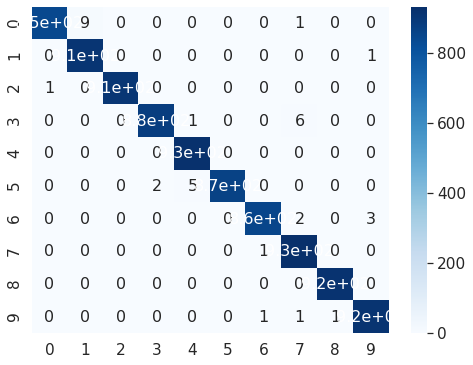

In [0]:


plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf, annot=True,annot_kws={"size": 16},cmap=plt.cm.Blues)# font size



In [0]:
x=(y_pre_test-y_test!=0).tolist()
x=[i for i,l in enumerate(x) if l!=False]

**The wrongly classified Digits are plotted. These digits are very difficult to classify for me as a native speaker. So the classification can concluded as successful.**

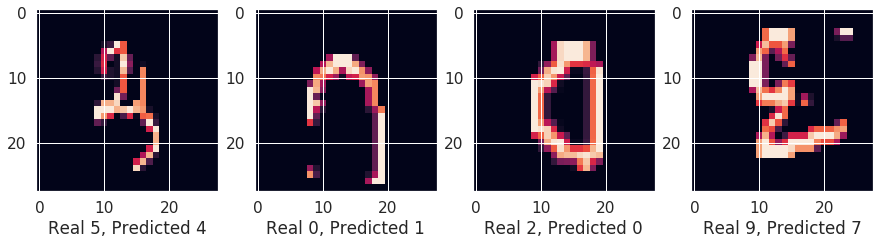

In [0]:
fig,ax=plt.subplots(1,4,sharey=False,figsize=(15,15))

for i in range(4):
    ax[i].imshow(X_test[x[i]][:,:,0])
    ax[i].set_xlabel('True label {}, Predicted label {}'.format(y_test[x[i]],y_pre_test[x[i]]))

Accuracy and Loss curves are plotted.

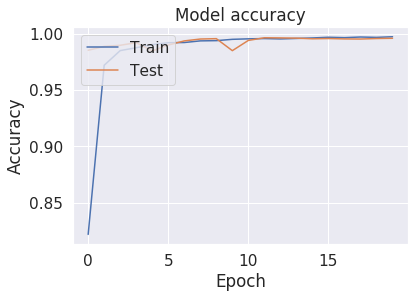

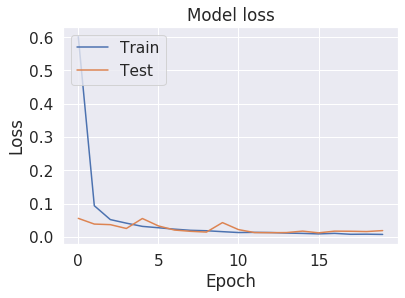

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
